In [1]:
# Importing Libraries
from scipy import stats
import pandas as pd
import numpy as np
import datetime
import warnings
import copy
import gc
import os

import seaborn as sns
from cycler import cycler
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import pyplot as plt, animation
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm


pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
gc.enable()

# Columns

* session_id - the ID of the session the event took place in
* index - the index of the event for the session
* elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
* event_name - the name of the event type
* name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
* level - what level of the game the event occurred in (0 to 22)
* page - the page number of the event (only for notebook-related events)
* room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
* room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
* screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
* screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
* hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
* text - the text the player sees during this event
* fqid - the fully qualified ID of the event
* room_fqid - the fully qualified ID of the room the event took place in
* text_fqid - the fully qualified ID of the
* fullscreen - whether the player is in fullscreen mode
* hq - whether the game is in high-quality
* music - whether the game music is on or off
* level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

In [2]:
directory = "/kaggle/input/predict-student-performance-from-game-play"
train_path = "/kaggle/input/predict-student-performance-from-game-play/train.csv"
test_path = "/kaggle/input/predict-student-performance-from-game-play/test.csv"
train_labels_path = "/kaggle/input/predict-student-performance-from-game-play/train_labels.csv"
sample_submission_path = "/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train_labels = pd.read_csv(train_labels_path)
sample_submission = pd.read_csv(sample_submission_path)

In [3]:
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [4]:
#Example output
sample_submission.head()

,session_id,correct,session_level
0,20090109393214576_q1,0,0
1,20090312143683264_q1,0,3
2,20090312331414616_q1,0,6
3,20090109393214576_q2,0,0
4,20090312143683264_q2,0,3


# Data Types

In [5]:
def get_dtypes(data_frame):
    dtypes = data_frame.dtypes
    dtypes = pd.DataFrame(dtypes).reset_index(drop=False)
    dtypes = dtypes.rename(columns={"index": "column", 0: "dtype"})
    
    return dtypes

dtypes = get_dtypes(train)

with pd.option_context("display.max_rows", None):
    display(dtypes)

,column,dtype
0,session_id,int64
1,index,int64
2,elapsed_time,int64
3,event_name,object
4,name,object
5,level,int64
6,page,float64
7,room_coor_x,float64
8,room_coor_y,float64
9,screen_coor_x,float64


# Optimization:

There are a lot of techniques to optimize data pre-processing (e.g Parallelling and reducing data types)

# First we will reduce the data type of string variables to 'category'. This will fascilitate faster loading of the data.

In [6]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


# Now we will try to reduce the memory usage

In [7]:
def get_memory_usage(data_frame, unit="MB"):
    memory_usage = data_frame.memory_usage().sum()
    
    if unit not in UNITS:
        raise ValueError(f"{unit} is not supported value for `unit`. Please, choose one of {UNITS}.")
        
    memory_usage /= (1024 ** (UNITS.index(unit) + 1))
    memory_usage = round(memory_usage, 2)
    
    return memory_usage

def reduce_memory_usage(data_frame, return_copy=True):
    """
    References:
        https://github.com/a-milenkin/ML_tricks_and_hacks/blob/main/dataframe_optimize.py
    """
    
    if return_copy:
        data_frame = copy.deepcopy(data_frame)
        
    for column, dtype in zip(data_frame.columns, data_frame.dtypes):
        dtype = str(dtype)
        column_data = data_frame[column]
        if any([_ in dtype for _ in ("int", "float")]):
            column_min, column_max = column_data.min(), column_data.max()
            if "int" in dtype:
                if (column_min > np.iinfo(np.int8).min) and (column_max < np.iinfo(np.int8).max):
                    column_data = column_data.astype(np.int8)
                elif (column_min > np.iinfo(np.int16).min) and (column_max < np.iinfo(np.int16).max):
                    column_data = column_data.astype(np.int16)
                elif (column_min > np.iinfo(np.int32).min) and (column_max < np.iinfo(np.int32).max):
                    column_data = column_data.astype(np.int32)
                else:
                    column_data = column_data.astype(np.int64)
            else:
                if (column_min > np.finfo(np.float16).min) and (column_max < np.finfo(np.float16).max):
                    column_data = column_data.astype(np.float16)
                elif (column_min > np.finfo(np.float32).min) and (column_max < np.finfo(np.float32).max):
                    column_data = column_data.astype(np.float32)
                else:
                    column_data = column_data.astype(np.float64)
        elif dtype == "object":
            column_data = column_data.astype("category")
        elif "datetime" in dtype:
            column_data = pd.to_datetime(column_data)
            
        data_frame[column] = column_data
        
    return data_frame
UNITS = ("KB", "MB", "GB", "TB")
unit = "MB"

memory_usage = get_memory_usage(train, unit=unit)
print(f"Memory usage of train dataset is {memory_usage} {unit}.")

train = reduce_memory_usage(train, return_copy=False)
optimized_memory_usage = get_memory_usage(train, unit=unit)
print(f"Memory usage of optimized train dataset is {optimized_memory_usage} {unit}.")

memory_usage_difference = (memory_usage - optimized_memory_usage)
memory_usage_percentage_difference = (memory_usage_difference / memory_usage) * 100
memory_usage_percentage_difference = round(memory_usage_percentage_difference, 2)
print(f"Memory usage of train dataset was decreased by {memory_usage_percentage_difference}%!")

print()

memory_usage = get_memory_usage(test, unit=unit)
print(f"Memory usage of test dataset is {memory_usage} {unit}.")

test = reduce_memory_usage(test, return_copy=False)
optimized_memory_usage = get_memory_usage(test, unit=unit)
print(f"Memory usage of optimized test dataset is {optimized_memory_usage} {unit}.")

memory_usage_difference = (memory_usage - optimized_memory_usage)
memory_usage_percentage_difference = (memory_usage_difference / memory_usage) * 100
memory_usage_percentage_difference = round(memory_usage_percentage_difference, 2)
print(f"Memory usage of test dataset was decreased by {memory_usage_percentage_difference}%!")

gc.collect()

Memory usage of train dataset is 4012.6 MB.
Memory usage of optimized train dataset is 1028.26 MB.
Memory usage of train dataset was decreased by 74.37%!

Memory usage of test dataset is 0.6 MB.
Memory usage of optimized test dataset is 0.17 MB.
Memory usage of test dataset was decreased by 71.67%!


0

# Duplicates

In [8]:
exclude_columns = ("index")
columns = [column for column in train.columns if column not in exclude_columns]
duplicates = train[train.duplicated(subset=columns)]

num_samples = len(train)
num_duplicates = len(duplicates)
print(f"Number of duplicates: {num_duplicates}")

duplicates_percentage = (num_duplicates / num_samples) * 100
duplicates_percentage = round(duplicates_percentage, 2)
print(f"Percentage of duplicates: {duplicates_percentage}%")
print()

duplicates

Number of duplicates: 1631
Percentage of duplicates: 0.01%



,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
100675,20100019210476400,510,1407980,navigate_click,undefined,15,NaN,-125.50000,-257.750000,711.0,549.0,NaN,NaN,NaN,tunic.historicalsociety.closet_dirty,NaN,0,0,1,13-22
120994,20100107574055690,192,160357,navigate_click,undefined,4,NaN,195.37500,47.312500,385.0,266.0,NaN,NaN,chap1_finale,tunic.capitol_0.hall,NaN,0,1,0,0-4
190655,20100110332615344,1043,1850611,cutscene_click,basic,16,NaN,-1049.00000,-12.804688,315.0,341.0,NaN,"Come on, Teddy.",confrontation,tunic.historicalsociety.cage,tunic.historicalsociety.cage.confrontation,0,0,0,13-22
223569,20100111374821010,535,795851,person_click,basic,10,NaN,-383.00000,201.875000,253.0,175.0,NaN,"Not sure. Here, let me look it up.",worker,tunic.library.frontdesk,tunic.library.frontdesk.worker.wells,0,1,1,5-12
350537,20100116221381640,163,201222,object_click,basic,3,NaN,706.50000,147.000000,717.0,183.0,NaN,NaN,plaque,tunic.kohlcenter.halloffame,NaN,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25713832,22080609460877892,412,259348,navigate_click,undefined,6,NaN,53.21875,-21.250000,490.0,334.0,NaN,NaN,NaN,tunic.historicalsociety.stacks,NaN,0,0,1,5-12
25776976,22090015143237204,891,1161081,navigate_click,undefined,19,NaN,884.00000,-507.250000,829.0,396.0,NaN,NaN,NaN,tunic.wildlife.center,NaN,0,0,1,13-22
25871857,22090114490010000,218,297330,object_click,basic,3,NaN,749.50000,-21.000000,760.0,351.0,NaN,NaN,plaque,tunic.kohlcenter.halloffame,NaN,1,1,1,0-4
25957014,22090215442091148,104,93791,person_click,basic,2,NaN,179.87500,-83.125000,545.0,386.0,NaN,I'll be at the Capitol. Let me know if you fin...,gramps,tunic.historicalsociety.collection,tunic.historicalsociety.collection.gramps.found,0,0,1,0-4


# Missing values

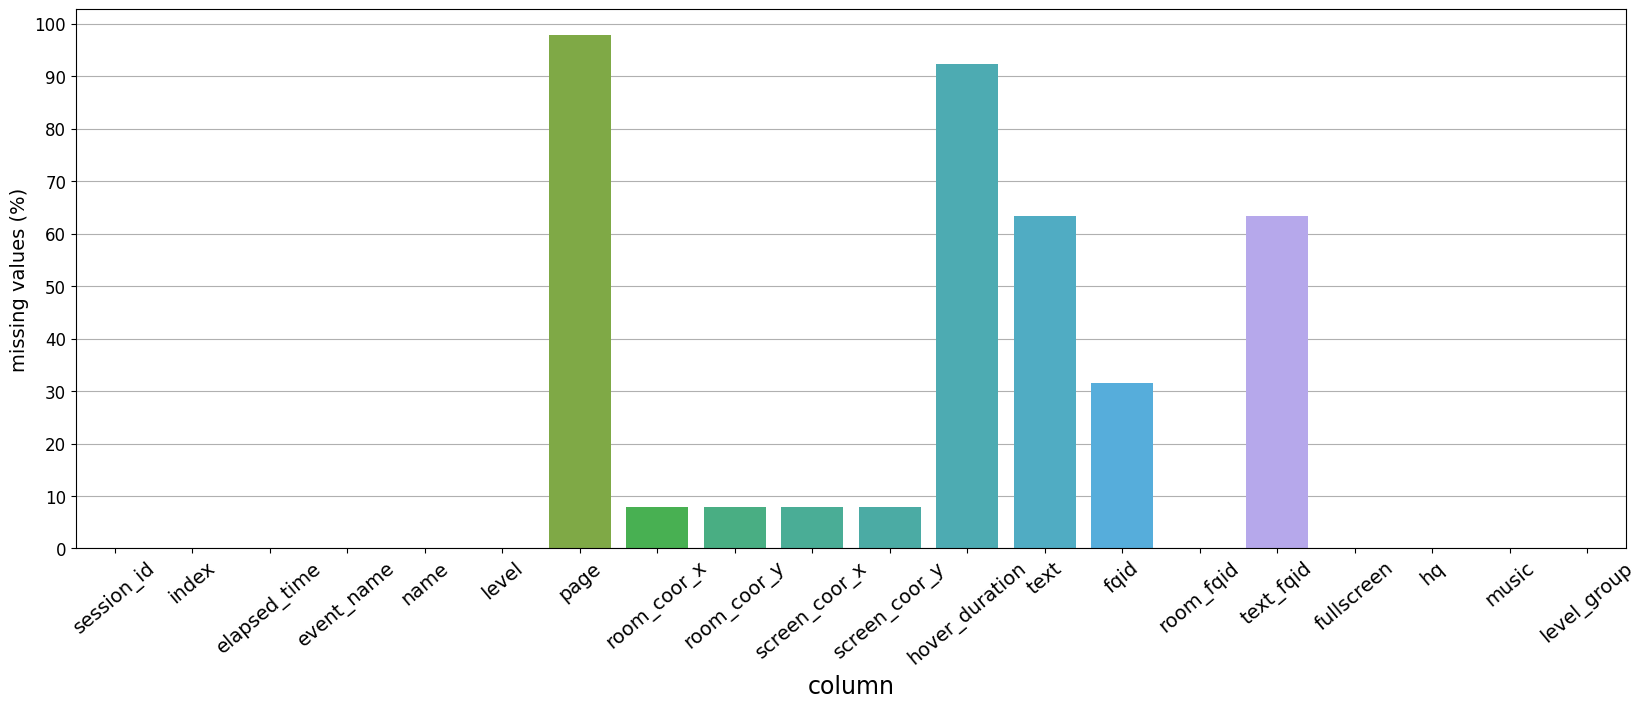

In [9]:
def get_missing_values(data_frame, stat="count"):
    missing_values = data_frame.isnull().sum()
    
    if stat == "percentage":
        num_samples = len(data_frame)
        missing_values = (missing_values / num_samples) * 100
    
    columns = missing_values.index.tolist()
    values = missing_values.values
    
    missing_values_data_frame = pd.DataFrame({
        "column": columns,
        "missing_values": values,
    })
    
    return missing_values_data_frame

missing_values = get_missing_values(train, stat="percentage")

figure = plt.figure(figsize=(20, 7))
axis = figure.add_subplot()
axis.grid(axis="y", zorder=0)
sns.barplot(x="column", y="missing_values", data=missing_values, label="Train dataset", alpha=1.0, linewidth=2.0, ax=axis, zorder=2)
axis.xaxis.set_tick_params(labelsize=14, rotation=40)
axis.set_xlabel("column", fontsize=17)
axis.yaxis.set_tick_params(labelsize=12)
axis.set_ylabel("missing values (%)", fontsize=14)
axis.set_yticks(range(0, 110, 10))
figure.show()

# Removing unnecessary columns:
Some columns don't have any information, so let's drop them

In [10]:
missed_columns = ["fullscreen", "hq", "music", "page", "hover_duration"]
train = train.drop(missed_columns, axis=1)
test = test.drop(missed_columns, axis=1)

# Distribution of classes of correct and incorrect responses:

An imbalance among classes can cause the model to be biased to more balanced classes, i.e it will be overfitted and won’t generalize well for imbalance classes.

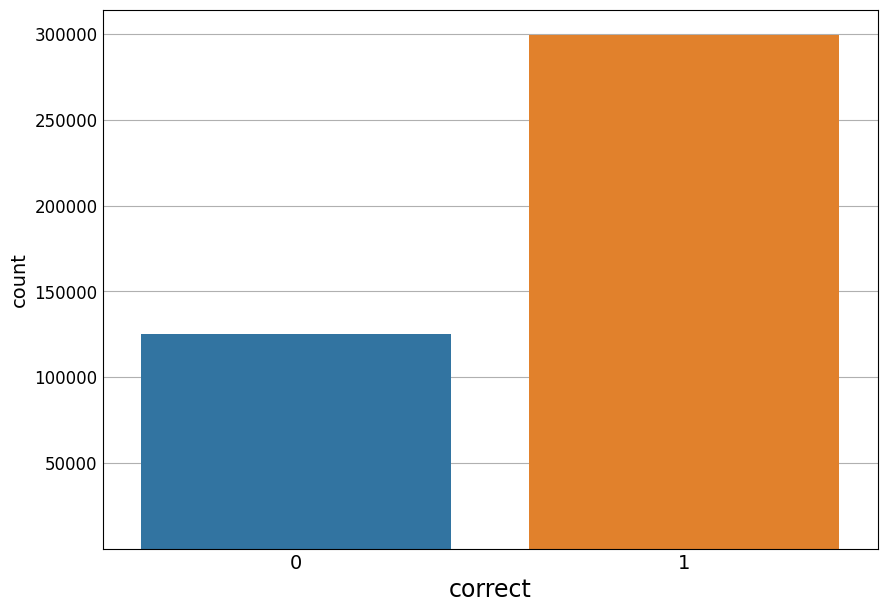

In [11]:
column = "correct"

figure = plt.figure(figsize=(10, 7))
axis = figure.add_subplot()
axis.grid(axis="y", zorder=0)
sns.countplot(x=column, data=train_labels, linewidth=2.0, ax=axis, zorder=2)
axis.xaxis.set_tick_params(size=0, labelsize=14)
axis.set_xlabel(column, fontsize=17)
axis.yaxis.set_tick_params(size=0, labelsize=12)
axis.set_ylabel("count", fontsize=14)
axis.tick_params(axis="both", which="both", length=0)
axis.set_ylim(1)
figure.show()

As we can see there is a slight class imbalance. To slightly smooth this problem: class-wise weights, oversampling or under-sampling, extracting external or generating synthetic data, and apply augmentations during training.



# Removing Outliers

 "num_events" and "elapsed_time" seem to have outliers

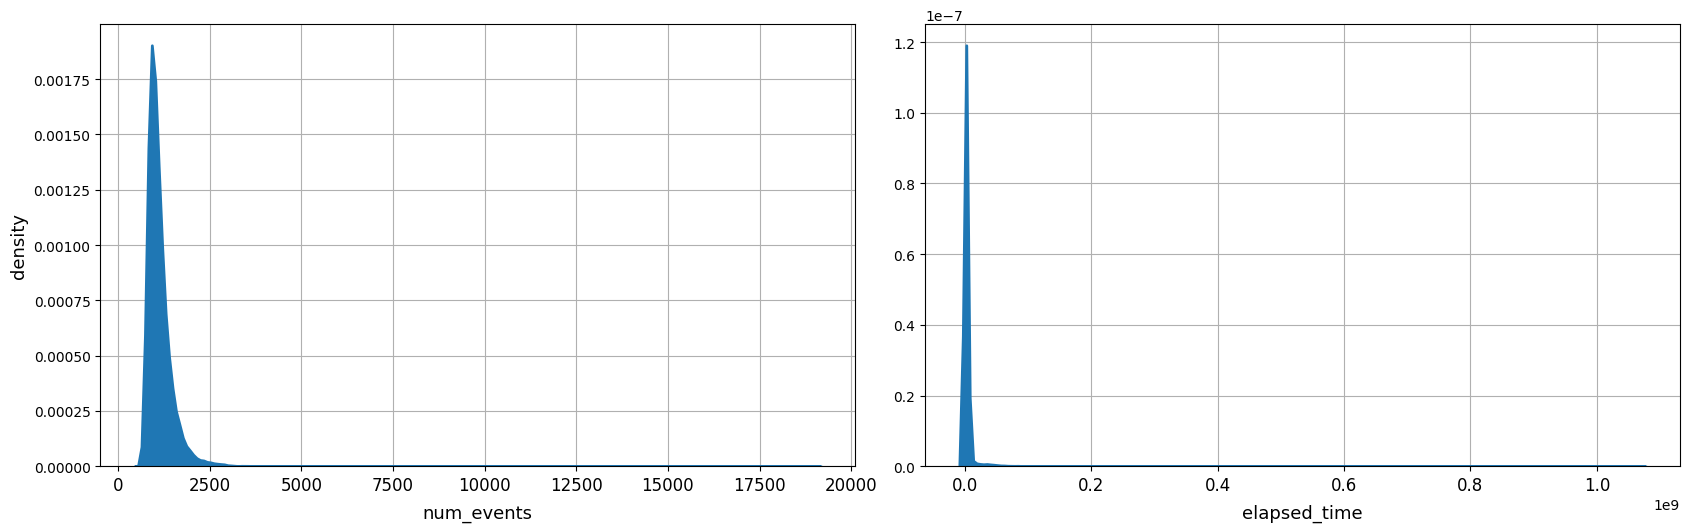

In [12]:
grouped_session = train.groupby("session_id")
session_wise_statistics = pd.DataFrame({
    "num_events": grouped_session.size(),
    "elapsed_time": grouped_session["elapsed_time"].mean(),
})
session_wise_columns = session_wise_statistics.columns
num_columns = len(session_wise_columns)

columns = 2
rows = (num_columns // columns)  + 1

figure = plt.figure(figsize=(17, 10))
for index, column in enumerate(session_wise_columns):
    data = session_wise_statistics[column].values
    
    axis = figure.add_subplot(rows, columns, index+1)
    axis.grid(axis="both", zorder=0)
    sns.kdeplot(x=data, fill=True, alpha=1.0,  linewidth=2, zorder=2, ax=axis)
    axis.xaxis.set_tick_params(labelsize=12)
    axis.set_xlabel(column, fontsize=13, labelpad=7)
    ylabel_text = "density"  if (index % columns) == 0 else ""
    axis.set_ylabel(ylabel_text, fontsize=13)
    axis.yaxis.set_tick_params(labelsize=10)

figure.tight_layout()
figure.show()

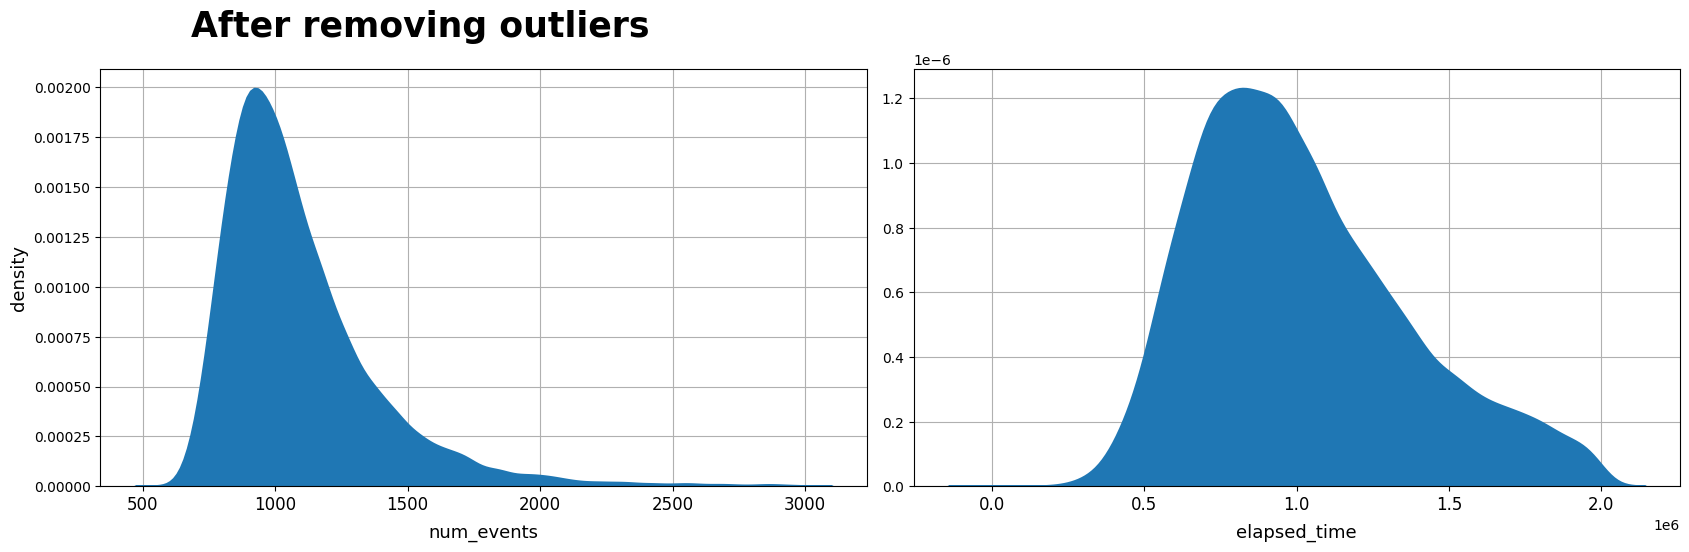

In [13]:
non_outliers_mask = (session_wise_statistics["num_events"] < 3000) & (session_wise_statistics["elapsed_time"] < 0.02*1e8)
non_outliers_session_wise_statistics = session_wise_statistics[non_outliers_mask]
session_wise_columns = non_outliers_session_wise_statistics.columns
num_columns = len(session_wise_columns)

columns = 2
rows = (num_columns // columns)  + 1

figure = plt.figure(figsize=(17, 10))
for index, column in enumerate(session_wise_columns):
    data = non_outliers_session_wise_statistics[column].values
    
    axis = figure.add_subplot(rows, columns, index+1)
    axis.grid(axis="both", zorder=0)
    sns.kdeplot(x=data, fill=True, alpha=1.0, linewidth=2, zorder=2, ax=axis)
    axis.xaxis.set_tick_params(labelsize=12)
    axis.set_xlabel(column, fontsize=13, labelpad=7)
    ylabel_text = "density"  if (index % columns) == 0 else ""
    axis.set_ylabel(ylabel_text, fontsize=13)
    axis.yaxis.set_tick_params(labelsize=10)

figure.suptitle("After removing outliers", x=0.25, fontsize=25, fontweight="bold")
figure.tight_layout()
figure.show()

# Time taken by students as levels increase

We can observe that as the levels increase students take more time to complete them

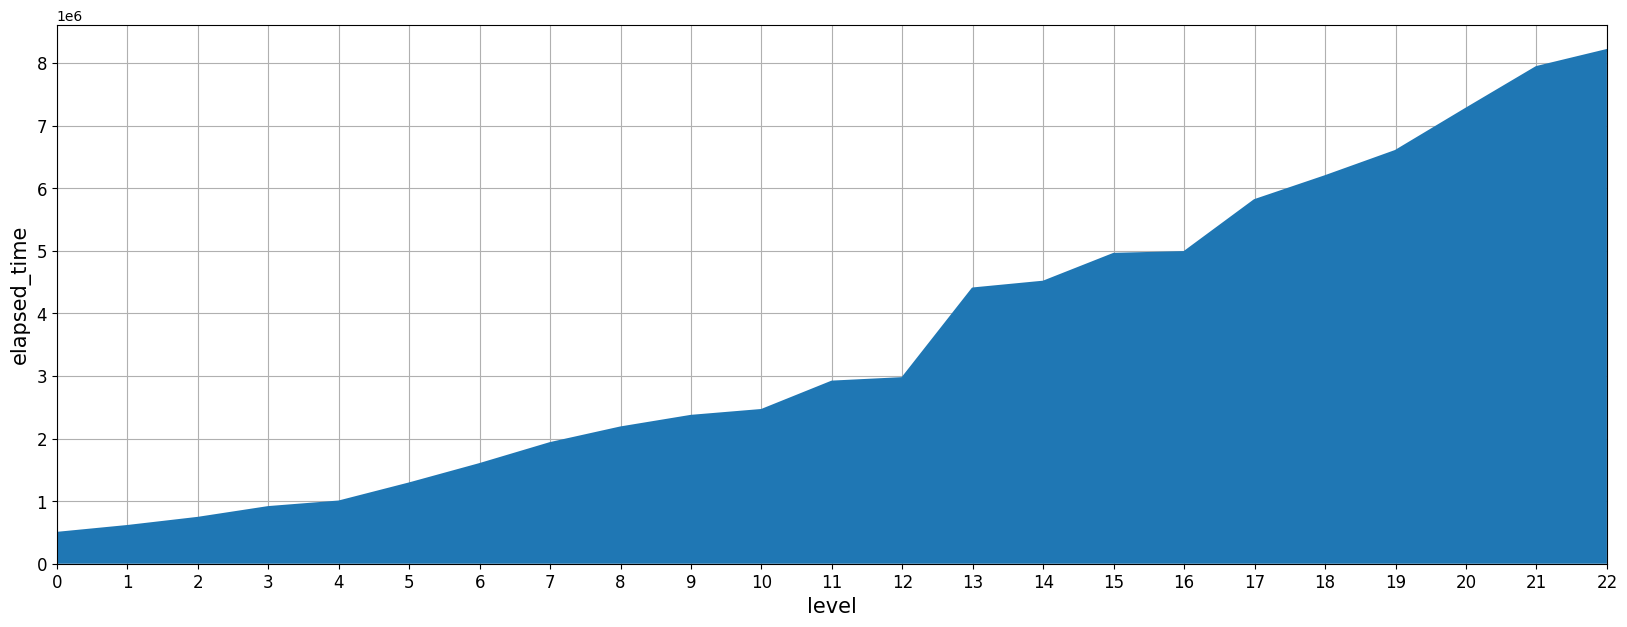

In [14]:
level_vs_elapsed_time = pd.DataFrame(train.groupby("level").agg({"elapsed_time": "mean"}))
level_vs_elapsed_time = level_vs_elapsed_time.reset_index(drop=False)
level_vs_elapsed_time.columns = ["level", "elapsed_time"]
level_vs_elapsed_time = level_vs_elapsed_time.sort_values(by="level", ascending=True)

x, y = level_vs_elapsed_time["level"].values, level_vs_elapsed_time["elapsed_time"]
min_x, max_x = np.min(x), np.max(x)

figure = plt.figure(figsize=(20, 7))
axis = figure.add_subplot()
axis.grid(axis="both", zorder=0)
sns.lineplot(x=x, y=y, linewidth=2, alpha=1.0, ax=axis, zorder=2)
axis.yaxis.set_tick_params(labelsize=14)
axis.set_ylabel("elapsed_time", fontsize=15)
axis.set_xlabel("level", fontsize=15)
axis.xaxis.set_tick_params(labelsize=12)
axis.yaxis.set_tick_params(labelsize=12)
axis.fill_between(x, y,alpha=1.0, zorder=2)
axis.set_xticks(range(min_x, max_x+1, 1))
axis.set_xlim(min_x, max_x)
axis.set_ylim(0.0)
figure.show()